In [20]:
# import findspark
# try:
#     findspark.init()
#     print("Spark found by findspark.")
# except:
#     print("Spark not found by findspark.")

In [21]:
!java -version

openjdk version "11.0.27" 2025-04-15
OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)


In [22]:
import sys
import os
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [23]:
from pyspark.sql.functions import col, concat_ws
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, NGram, HashingTF, IDF
from pyspark.sql.functions import col
from sklearn.feature_extraction.text import TfidfVectorizer
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import split, trim, size
from pyspark.sql.functions import length
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import StringIndexer
from textblob import TextBlob
from pyspark.ml import Pipeline
from imblearn.over_sampling import SMOTE
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from collections import Counter
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import explode, lit, rand
import pyspark.sql.functions as F
from wordcloud import WordCloud,STOPWORDS
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import re
import string
import pandas as pd
from pyspark.sql.types import FloatType

In [24]:
reviews = pd.read_csv('Musical_instruments_reviews.csv')

In [25]:
MIN_TOKEN_LENGTH = 2
SPARK_MEMORY = "8g"

spark = SparkSession.builder \
    .appName("Amazon Sentiment Analysis") .config("spark.driver.memory", SPARK_MEMORY) \
    .getOrCreate()

df3 = spark.read.csv("Musical_instruments_reviews.csv", header=True)

In [26]:
df = spark.createDataFrame(reviews)

In [27]:
#
df3.show(5)

+--------------+----------+--------------------+--------+--------------------+-------+--------------------+--------------------+-----------+
|    reviewerID|      asin|        reviewerName| helpful|          reviewText|overall|             summary|      unixReviewTime| reviewTime|
+--------------+----------+--------------------+--------+--------------------+-------+--------------------+--------------------+-----------+
|A2IBPI20UZIR0U|1384719342|"cassandra tu ""Yeah|    well|    that's just like|  u..."|              [0, 0]|Not much to write...|        5.0|
|A14VAT5EAX3D9S|1384719342|                Jake|[13, 14]|The product does ...|    5.0|                Jake|          1363392000|03 16, 2013|
|A195EZSQDW3E21|1384719342|"Rick Bennette ""...|  [1, 1]|The primary job o...|    5.0|It Does The Job Well|          1377648000|08 28, 2013|
|A2C00NNG1ZQQG2|1384719342|"RustyBill ""Sund...|  [0, 0]|Nice windscreen p...|    5.0|GOOD WINDSCREEN F...|          1392336000|02 14, 2014|
| A94QU4C90B1

In [28]:
df = df3.fillna({'reviewText': 'Missing'})

In [29]:
# Combine 'reviewText' and 'summary' into a new column 'reviews'
df = df.withColumn('reviews', concat_ws('', col('reviewText'), col('summary')))

# Drop the original 'reviewText' and 'summary' columns
df = df.drop('reviewText', 'summary')

In [30]:
df.show()

+--------------+----------+--------------------+--------+-------+--------------------+-----------+--------------------+
|    reviewerID|      asin|        reviewerName| helpful|overall|      unixReviewTime| reviewTime|             reviews|
+--------------+----------+--------------------+--------+-------+--------------------+-----------+--------------------+
|A2IBPI20UZIR0U|1384719342|"cassandra tu ""Yeah|    well|  u..."|Not much to write...|        5.0| that's just like...|
|A14VAT5EAX3D9S|1384719342|                Jake|[13, 14]|    5.0|          1363392000|03 16, 2013|The product does ...|
|A195EZSQDW3E21|1384719342|"Rick Bennette ""...|  [1, 1]|    5.0|          1377648000|08 28, 2013|The primary job o...|
|A2C00NNG1ZQQG2|1384719342|"RustyBill ""Sund...|  [0, 0]|    5.0|          1392336000|02 14, 2014|Nice windscreen p...|
| A94QU4C90B1AX|1384719342|       SEAN MASLANKA|  [0, 0]|    5.0|          1392940800|02 21, 2014|This pop filter i...|
|A2A039TZMZHH9Y|B00004Y2UT|"Bill Lewey "

In [31]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, IntegerType

# Cast the column to IntegerType
df = df.withColumn("overall", col("overall").cast(IntegerType()))

# Define the sentiment function
def sent(overall):
    if overall is None:
        return 'Unknown'
    elif overall == 3:
        return 'Neutral'
    elif overall > 3:
        return 'Positive'
    else:
        return 'Negative'

# Register the UDF
sent_udf = udf(sent, StringType())

# Apply the UDF
df = df.withColumn("Sentiment", sent_udf(col("overall")))




In [32]:
df.show(10)

+--------------+----------+--------------------+--------+-------+--------------------+-----------+--------------------+---------+
|    reviewerID|      asin|        reviewerName| helpful|overall|      unixReviewTime| reviewTime|             reviews|Sentiment|
+--------------+----------+--------------------+--------+-------+--------------------+-----------+--------------------+---------+
|A2IBPI20UZIR0U|1384719342|"cassandra tu ""Yeah|    well|   NULL|Not much to write...|        5.0| that's just like...|  Unknown|
|A14VAT5EAX3D9S|1384719342|                Jake|[13, 14]|      5|          1363392000|03 16, 2013|The product does ...| Positive|
|A195EZSQDW3E21|1384719342|"Rick Bennette ""...|  [1, 1]|      5|          1377648000|08 28, 2013|The primary job o...| Positive|
|A2C00NNG1ZQQG2|1384719342|"RustyBill ""Sund...|  [0, 0]|      5|          1392336000|02 14, 2014|Nice windscreen p...| Positive|
| A94QU4C90B1AX|1384719342|       SEAN MASLANKA|  [0, 0]|      5|          1392940800|02 2

In [33]:


# Split 'reviewTime' into 'date' and 'year'
df = df.withColumn('date', split(df['reviewTime'], ',').getItem(0))
df = df.withColumn('year', trim(split(df['reviewTime'], ',').getItem(1)))

# Split 'date' into 'month' and 'day'
df = df.withColumn('month', split(df['date'], ' ').getItem(0))
df = df.withColumn('day', split(df['date'], ' ').getItem(1))

# Drop 'reviewTime' and 'date' columns
df = df.drop('reviewTime', 'date')

# Show the result
df.show(5)


+--------------+----------+--------------------+--------+-------+--------------------+--------------------+---------+----+-----+----+
|    reviewerID|      asin|        reviewerName| helpful|overall|      unixReviewTime|             reviews|Sentiment|year|month| day|
+--------------+----------+--------------------+--------+-------+--------------------+--------------------+---------+----+-----+----+
|A2IBPI20UZIR0U|1384719342|"cassandra tu ""Yeah|    well|   NULL|Not much to write...| that's just like...|  Unknown|NULL|  5.0|NULL|
|A14VAT5EAX3D9S|1384719342|                Jake|[13, 14]|      5|          1363392000|The product does ...| Positive|2013|   03|  16|
|A195EZSQDW3E21|1384719342|"Rick Bennette ""...|  [1, 1]|      5|          1377648000|The primary job o...| Positive|2013|   08|  28|
|A2C00NNG1ZQQG2|1384719342|"RustyBill ""Sund...|  [0, 0]|      5|          1392336000|Nice windscreen p...| Positive|2014|   02|  14|
| A94QU4C90B1AX|1384719342|       SEAN MASLANKA|  [0, 0]|     

In [34]:
df = df.drop('reviewerName', 'unixReviewTime')

In [35]:
def clean_review(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [36]:
clean_review_udf = udf(clean_review, StringType())

In [37]:
df = df.withColumn('reviews', clean_review_udf(df['reviews']))

In [38]:
df.show(5)


+--------------+----------+--------+-------+--------------------+---------+----+-----+----+
|    reviewerID|      asin| helpful|overall|             reviews|Sentiment|year|month| day|
+--------------+----------+--------+-------+--------------------+---------+----+-----+----+
|A2IBPI20UZIR0U|1384719342|    well|   NULL|     thats just like|  Unknown|NULL|  5.0|NULL|
|A14VAT5EAX3D9S|1384719342|[13, 14]|      5|the product does ...| Positive|2013|   03|  16|
|A195EZSQDW3E21|1384719342|  [1, 1]|      5|the primary job o...| Positive|2013|   08|  28|
|A2C00NNG1ZQQG2|1384719342|  [0, 0]|      5|nice windscreen p...| Positive|2014|   02|  14|
| A94QU4C90B1AX|1384719342|  [0, 0]|      5|this pop filter i...| Positive|2014|   02|  21|
+--------------+----------+--------+-------+--------------------+---------+----+-----+----+
only showing top 5 rows



In [39]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each',
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above',
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't",
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from',
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs',
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

def remove_stopwords(text):
    if text is None:
        return ""
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return ' '.join(filtered)

remove_stopwords_udf = udf(remove_stopwords, StringType())


In [40]:
df = df.withColumn('reviews', remove_stopwords_udf(df['reviews']))

In [41]:
def get_polarity(text):
    try:
        return float(TextBlob(str(text)).sentiment.polarity)
    except:
        return 0.0

polarity_udf = udf(get_polarity, FloatType())
df = df.withColumn('polarity', polarity_udf(df['reviews']))

In [42]:
df = df.withColumn('review_len', length(df['reviews']))
df = df.withColumn('word_count', size(split(df['reviews'], ' ')))

df.select('reviews', 'polarity', 'review_len', 'word_count').show(5)

+--------------------+-----------+----------+----------+
|             reviews|   polarity|review_len|word_count|
+--------------------+-----------+----------+----------+
|          thats like|        0.0|        10|         2|
|product exactly q...|0.014285714|       356|        55|
|primary job devic...|     0.1675|       315|        48|
|nice windscreen p...| 0.33333334|       169|        22|
|pop filter great ...|        0.8|       136|        21|
+--------------------+-----------+----------+----------+
only showing top 5 rows



In [43]:
positive_review = df.filter(df["Sentiment"] == 'Positive').na.drop()
neutral_review  = df.filter(df["Sentiment"] == 'Neutral').na.drop()
negative_review = df.filter(df["Sentiment"] == 'Negative').na.drop()

In [44]:
negative_review.show(10)

+--------------+----------+-------+-------+--------------------+---------+----+-----+---+------------+----------+----------+
|    reviewerID|      asin|helpful|overall|             reviews|Sentiment|year|month|day|    polarity|review_len|word_count|
+--------------+----------+-------+-------+--------------------+---------+----+-----+---+------------+----------+----------+
|A2PD27UKAD3Q00|B00005ML71| [0, 0]|      2|bought use keyboa...| Negative|2013|   08| 17|  0.26944444|       430|        63|
|A12ABV9NU02O29|B000068NW5| [2, 2]|      2|didnt expect cabl...| Negative|2011|   07|  6|-0.018707482|       281|        41|
|A1L7M2JXN4EZCR|B000068NW5| [0, 0]|      1|hums crackles thi...| Negative|2014|   02|  9|         0.6|       183|        29|
|A3UD50M7M72150|B000068NW5| [0, 0]|      1|im procheapo hate...| Negative|2014|   03| 14|       -0.25|       106|        16|
|A1W3CEEQBJ4GTN|B000068NZC| [0, 0]|      2|bought canon vixi...| Negative|2013|   09| 16|   0.0734127|       620|       100|


In [45]:
df.printSchema()


root
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- helpful: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- reviews: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- polarity: float (nullable = true)
 |-- review_len: integer (nullable = true)
 |-- word_count: integer (nullable = false)



In [46]:
df.select("Sentiment").limit(5).show()


+---------+
|Sentiment|
+---------+
|  Unknown|
| Positive|
| Positive|
| Positive|
| Positive|
+---------+



In [47]:
df.show(5)

+--------------+----------+--------+-------+--------------------+---------+----+-----+----+-----------+----------+----------+
|    reviewerID|      asin| helpful|overall|             reviews|Sentiment|year|month| day|   polarity|review_len|word_count|
+--------------+----------+--------+-------+--------------------+---------+----+-----+----+-----------+----------+----------+
|A2IBPI20UZIR0U|1384719342|    well|   NULL|          thats like|  Unknown|NULL|  5.0|NULL|        0.0|        10|         2|
|A14VAT5EAX3D9S|1384719342|[13, 14]|      5|product exactly q...| Positive|2013|   03|  16|0.014285714|       356|        55|
|A195EZSQDW3E21|1384719342|  [1, 1]|      5|primary job devic...| Positive|2013|   08|  28|     0.1675|       315|        48|
|A2C00NNG1ZQQG2|1384719342|  [0, 0]|      5|nice windscreen p...| Positive|2014|   02|  14| 0.33333334|       169|        22|
| A94QU4C90B1AX|1384719342|  [0, 0]|      5|pop filter great ...| Positive|2014|   02|  21|        0.8|       136|    

In [48]:
df.cache()


DataFrame[reviewerID: string, asin: string, helpful: string, overall: int, reviews: string, Sentiment: string, year: string, month: string, day: string, polarity: float, review_len: int, word_count: int]

In [49]:
# pdf = df.select("*").toPandas()
# from sklearn import preprocessing

# le = preprocessing.LabelEncoder()
# pdf['Sentiment'] = le.fit_transform(pdf['Sentiment'])
# df = spark.createDataFrame(pdf)

In [50]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Sentiment", outputCol="Sentiment_Indexed")
indexer_model = indexer.fit(df)
df = indexer_model.transform(df)
df.select("Sentiment", "Sentiment_Indexed").distinct().show()

+---------+-----------------+
|Sentiment|Sentiment_Indexed|
+---------+-----------------+
| Positive|              0.0|
|  Unknown|              1.0|
|  Neutral|              2.0|
| Negative|              3.0|
+---------+-----------------+



In [51]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer

spark = SparkSession.builder.getOrCreate()
data = [("Positive",), ("Negative",), ("Neutral",)]
df2 = spark.createDataFrame(data, ["Sentiment"])
indexer = StringIndexer(inputCol="Sentiment", outputCol="Sentiment_Indexed")
model = indexer.fit(df2)
df2 = model.transform(df2)
df2.show()

+---------+-----------------+
|Sentiment|Sentiment_Indexed|
+---------+-----------------+
| Positive|              2.0|
| Negative|              0.0|
|  Neutral|              1.0|
+---------+-----------------+



In [52]:
df.groupBy('Sentiment').count().orderBy('count', ascending=False).show()

+---------+-----+
|Sentiment|count|
+---------+-----+
| Positive| 8387|
|  Unknown|  753|
|  Neutral|  699|
| Negative|  422|
+---------+-----+



In [53]:
# Extracting 'reviews' for processing
df_features = df.select("reviews").alias("review_features")
df_features.show(5)

+--------------------+
|             reviews|
+--------------------+
|          thats like|
|product exactly q...|
|primary job devic...|
|nice windscreen p...|
|pop filter great ...|
+--------------------+
only showing top 5 rows



In [54]:
review_features = df

In [55]:
df2=df.toPandas()

In [56]:
df2.head()

,reviewerID,asin,helpful,overall,reviews,Sentiment,year,month,day,polarity,review_len,word_count,Sentiment_Indexed
0,A2IBPI20UZIR0U,1384719342,well,NaN,thats like,Unknown,None,5.0,None,0.000000,10,2,1.0
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5.0,product exactly quite affordablei not realized...,Positive,2013,03,16,0.014286,356,55,0.0
2,A195EZSQDW3E21,1384719342,"[1, 1]",5.0,primary job device block breath would otherwis...,Positive,2013,08,28,0.167500,315,48,0.0
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5.0,nice windscreen protects mxl mic prevents pops...,Positive,2014,02,14,0.333333,169,22,0.0
4,A94QU4C90B1AX,1384719342,"[0, 0]",5.0,pop filter great looks performs like studio fi...,Positive,2014,02,21,0.800000,136,21,0.0


In [57]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [58]:
# 1. Tokenization
tokenizer = Tokenizer(inputCol="reviews", outputCol="words")
df_tokenized = tokenizer.transform(df)
df_tokenized.show()

+--------------+----------+--------+-------+--------------------+---------+----+-----+----+-----------+----------+----------+-----------------+--------------------+
|    reviewerID|      asin| helpful|overall|             reviews|Sentiment|year|month| day|   polarity|review_len|word_count|Sentiment_Indexed|               words|
+--------------+----------+--------+-------+--------------------+---------+----+-----+----+-----------+----------+----------+-----------------+--------------------+
|A2IBPI20UZIR0U|1384719342|    well|   NULL|          thats like|  Unknown|NULL|  5.0|NULL|        0.0|        10|         2|              1.0|       [thats, like]|
|A14VAT5EAX3D9S|1384719342|[13, 14]|      5|product exactly q...| Positive|2013|   03|  16|0.014285714|       356|        55|              0.0|[product, exactly...|
|A195EZSQDW3E21|1384719342|  [1, 1]|      5|primary job devic...| Positive|2013|   08|  28|     0.1675|       315|        48|              0.0|[primary, job, de...|
|A2C00NNG1

In [59]:
df_tokenized.printSchema()

root
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- helpful: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- reviews: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- polarity: float (nullable = true)
 |-- review_len: integer (nullable = true)
 |-- word_count: integer (nullable = false)
 |-- Sentiment_Indexed: double (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [60]:
# # cHECKING FOR MISSPELLED WORDS
# # Configuration

# DOMAIN_WORDS = [
#     "epiphone", "fender", "windscreen", "yamaha", "ive", "monster",
#     "plugin", "bluetooth", "mic", "ipad", "ipod", "amps", "distortion",
#     "gig", "amp", "aux", "acoustic", "pedal", "tuner", "preamp",
#     "podcast", "adapter", "playlist"
# ]
# # Initialize spell checker
# def init_spell_checker():
#     checker = SpellChecker()
#     checker.word_frequency.load_words(DOMAIN_WORDS)
#     return checker

# # Spell-check function
# @pandas_udf(ArrayType(StringType()))
# def check_misspellings(tokens: pd.Series) -> pd.Series:
#     checker = init_spell_checker()
#     def check_tokens(token_list):
#         # Handle None or non-list inputs
#         if token_list is None or not isinstance(token_list, (list, tuple)):
#             return []
#         # Handle empty lists
#         if len(token_list) == 0:
#             return []
#         # Process valid tokens
#         valid_tokens = [t.lower() for t in token_list if isinstance(t, str) and len(t) >= MIN_TOKEN_LENGTH and not t.isdigit()]
#         return list(checker.unknown(valid_tokens))
#     return tokens.apply(check_tokens)

# # Main processing
# def main(df_tokenized):
#     # Cache and repartition
#     df_tokenized.cache()
#     df_tokenized = df_tokenized.repartition(8)  # Adjust based on cores

#     # Add misspelled words column
#     result_df = df_tokenized.withColumn("misspelled_words", check_misspellings("words"))

#     # Show sample results
#     print("Sample rows with misspellings:")
#     result_df.select("reviewerID", "reviews", "words", "misspelled_words").show(5, truncate=False)

#     # Count total misspelled words
#     misspelling_count = result_df.select(explode("misspelled_words").alias("misspelled_word")).count()
#     print(f"Total number of misspelled words: {misspelling_count}")

#     # Cleanup
#     df_tokenized.unpersist()


# # Run spell-checking (assuming df_tokenized is loaded)
# main(df_tokenized)

# # Optional: Stop SparkSession
# # spark.stop()

In [61]:
! pip install spacy

In [62]:
# 2. Lemmatization UDF
import spacy
from pyspark.sql.functions import udf, col, size
from pyspark.sql.types import ArrayType, StringType

nlp = spacy.load('en_core_web_sm')

def lemmatize(tokens):
    # Handle None, non-list, or empty inputs
    if not tokens or not isinstance(tokens, (list, tuple)) or len(tokens) == 0:
        return []
    # Join tokens into a string for SpaCy processing
    text = " ".join([t for t in tokens if isinstance(t, str)])
    # Process the text with SpaCy NLP pipeline
    doc = nlp(text)
    # Return all lemmas, without filtering stopwords or punctuation
    return [token.lemma_ for token in doc if not token.is_punct]

# Register the UDF with PySpark
lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

# Apply the UDF to create the 'lemmatized' column
df_tokenized = df_tokenized.withColumn("lemmatized", lemmatize_udf(df_tokenized["words"]))

# Add word counts for validation
df_tokenized = df_tokenized.withColumn("words_count", size(col("words"))) \
                           .withColumn("lemmatized_count", size(col("lemmatized")))

# Show the results
print("Sample rows with lemmatization:")
df_tokenized.select("reviews", "words", "lemmatized", "words_count", "lemmatized_count").show(10, truncate=False)

# Validation checks
total_rows = df_tokenized.count()
non_null_lemmatized = df_tokenized.filter(col("lemmatized").isNotNull()).count()
non_empty_lemmatized = df_tokenized.filter(size(col("lemmatized")) > 0).count()

print(f"Total rows: {total_rows}")
print(f"Rows with non-null lemmatized column: {non_null_lemmatized}")
print(f"Rows with non-empty lemmatized lists: {non_empty_lemmatized}")

print("Rows with empty lemmatized lists (if any):")
df_tokenized.filter(size(col("lemmatized")) == 0) \
            .select("reviewerID", "reviews", "words", "lemmatized") \
            .show(5, truncate=False)

Sample rows with lemmatization:
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [74]:
# 3. TF-IDF Vectorization
from pyspark.ml.feature import HashingTF, IDF
from pyspark.sql.functions import col

# Configure HashingTF
hashing_tf = HashingTF(inputCol="lemmatized", outputCol="raw_features", numFeatures=10000)

# Configure IDF
idf = IDF(inputCol="raw_features", outputCol="tfidf")

# Apply HashingTF to create term frequency vectors
df_tokenized = hashing_tf.transform(df_tokenized)

# Apply IDF to compute TF-IDF scores
df_tokenized = idf.fit(df_tokenized).transform(df_tokenized)

# Show the results
print("Sample rows with TF-IDF:")
df_tokenized.select("reviews", "lemmatized", "tfidf").show(10, truncate=False)

IllegalArgumentException: requirement failed: Column raw_features already exists.

In [73]:
df_tokenized.printSchema()

root
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- helpful: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- reviews: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- polarity: float (nullable = true)
 |-- review_len: integer (nullable = true)
 |-- word_count: integer (nullable = false)
 |-- Sentiment_Indexed: double (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- lemmatized: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_count: integer (nullable = false)
 |-- lemmatized_count: integer (nullable = false)
 |-- raw_features: vector (nullable = true)
 |-- tfidf: vector (nullable = true)



In [65]:
columns_to_drop = [
    "asin",
    "reviewerID",
    "reviews",
    "Sentiment",
    "overall",
    "words",
    "lemmatized",
    "words_count",
    "lemmatized_count",
    "helpful",
    "year",
    "month",
    "day"

]

df_cleaned = df_tokenized.drop(*columns_to_drop)

In [66]:
df_cleaned.printSchema()

root
 |-- polarity: float (nullable = true)
 |-- review_len: integer (nullable = true)
 |-- word_count: integer (nullable = false)
 |-- Sentiment_Indexed: double (nullable = false)
 |-- raw_features: vector (nullable = true)
 |-- tfidf: vector (nullable = true)



In [67]:
# Group by the target column and count
df_cleaned.groupBy("Sentiment_Indexed").count().orderBy("Sentiment_Indexed").show()


+-----------------+-----+
|Sentiment_Indexed|count|
+-----------------+-----+
|              0.0| 8387|
|              1.0|  753|
|              2.0|  699|
|              3.0|  422|
+-----------------+-----+



In [68]:
from pyspark.sql import functions as F

# Calculate the number of samples in the majority class (class 0)
major_class_count = df_cleaned.filter(F.col("Sentiment_Indexed") == 0.0).count()

# Get the dataframes for each class
df_class0 = df_cleaned.filter(F.col("Sentiment_Indexed") == 0.0)
df_class1 = df_cleaned.filter(F.col("Sentiment_Indexed") == 1.0)
df_class2 = df_cleaned.filter(F.col("Sentiment_Indexed") == 2.0)

# Calculate the oversampling fraction for minority classes
fraction1 = float(major_class_count) / df_class1.count()
fraction2 = float(major_class_count) / df_class2.count()

# Oversample the minority classes
df_class1_oversampled = df_class1.sample(withReplacement=True, fraction=fraction1, seed=42)
df_class2_oversampled = df_class2.sample(withReplacement=True, fraction=fraction2, seed=42)

# Combine the oversampled dataframes with the majority class
df_balanced = df_class0.union(df_class1_oversampled).union(df_class2_oversampled)

# Check the balance of the new dataframe
df_balanced.groupBy("Sentiment_Indexed").count().orderBy("Sentiment_Indexed").show()

# If you need to shuffle the dataset (recommended)
df_balanced = df_balanced.orderBy(F.rand(seed=42))

+-----------------+-----+
|Sentiment_Indexed|count|
+-----------------+-----+
|              0.0| 8387|
|              1.0| 8431|
|              2.0| 8472|
+-----------------+-----+



In [69]:

# Split the data (80% train, 10% validation, 10% test)
train_data, val_data, test_data = df_balanced.randomSplit([0.8, 0.1, 0.1], seed=42)

# Cache the dataframes for better performance
train_data.cache()
val_data.cache()
test_data.cache()

DataFrame[polarity: float, review_len: int, word_count: int, Sentiment_Indexed: double, raw_features: vector, tfidf: vector]

Training Logistic Regression...
Completed Logistic Regression
Training Decision Tree...
Completed Decision Tree
Training Random Forest...
Completed Random Forest
Training Naive Bayes...
Completed Naive Bayes
Training KNN (Approximate)...
Error with KNN (Approximate): [FIELD_NOT_FOUND] No such struct field `id` in `polarity`, `review_len`, `word_count`, `Sentiment_Indexed`, `raw_features`, `tfidf`, `hashes`.
Completed KNN (Approximate)

Model Comparison:
                 Model  F1 Score  Precision    Recall  Accuracy  \
0  Logistic Regression  0.941950   0.943153  0.942700  0.942700   
3          Naive Bayes  0.855284   0.856661  0.856358  0.856358   
2        Random Forest  0.624353   0.629762  0.624804  0.624804   
1        Decision Tree  0.489463   0.547433  0.508634  0.508634   
4    KNN (Approximate)  0.000000   0.000000  0.000000  0.000000   

   Training Time (s)                                              Error  
0         836.247478                                             

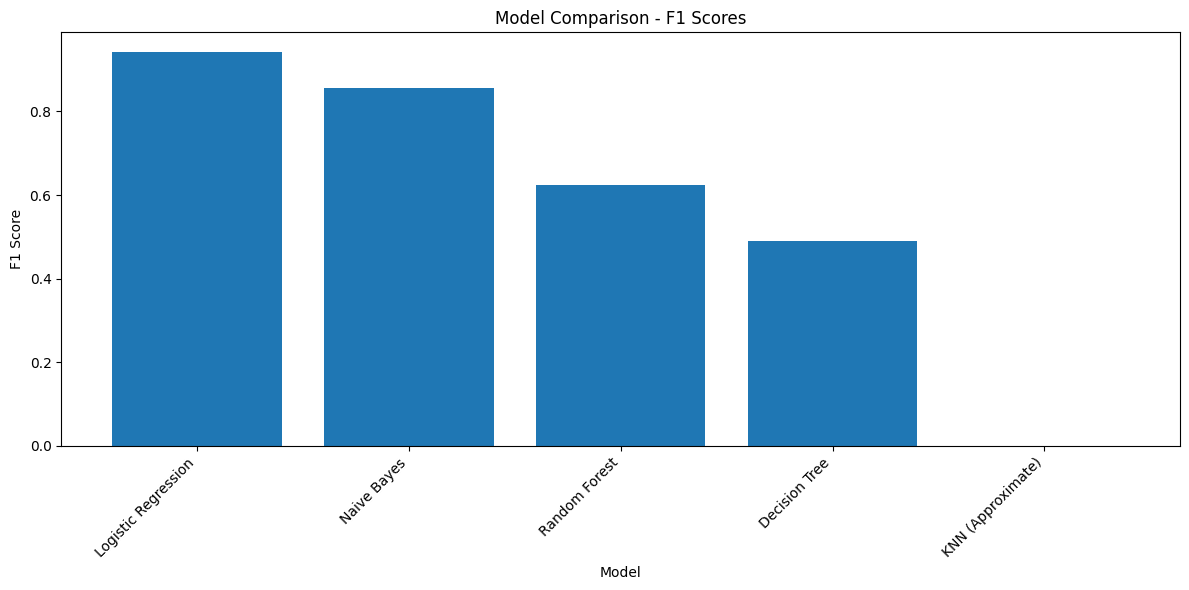

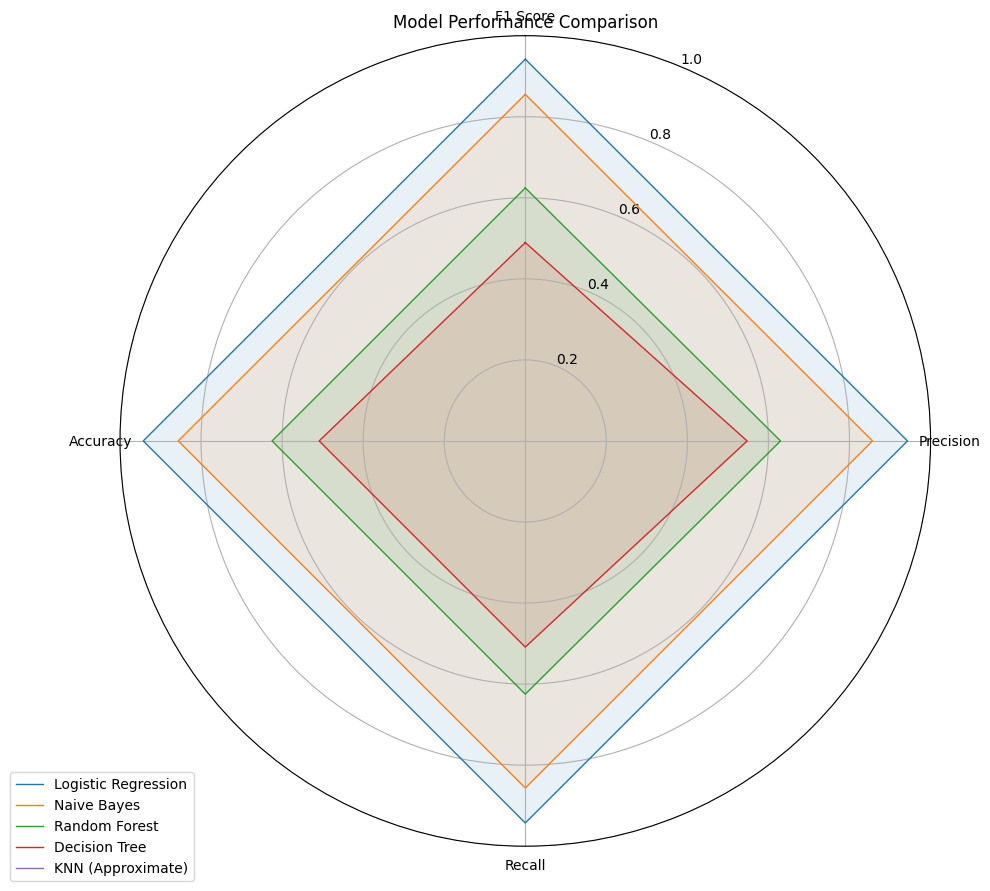

In [70]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, LinearSVC, GBTClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
import time
import pandas as pd
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np



# If you want to combine tfidf + numeric features later, we can update

# Create KNN approximation using LSH on 'tfidf' features
def knn_predict(train_data, val_data, k=5):
    """
    Approximate KNN in PySpark using Locality Sensitive Hashing on TF-IDF features
    """
    brp = BucketedRandomProjectionLSH(
        inputCol="tfidf",
        outputCol="hashes",
        numHashTables=5,
        bucketLength=2.0
    )
    brp_model = brp.fit(train_data)

    train_hashed = brp_model.transform(train_data)
    val_hashed = brp_model.transform(val_data)

    val_with_neighbors = brp_model.approxSimilarityJoin(
        val_hashed,
        train_hashed,
        threshold=100.0,
        distCol="distance"
    )

    window = Window.partitionBy("datasetA.id").orderBy("distance")
    val_with_knn = val_with_neighbors.withColumn("rank", F.row_number().over(window))
    val_with_knn = val_with_knn.filter(F.col("rank") <= k)

    val_predictions = val_with_knn.groupBy("datasetA.id") \
        .agg(
            F.first("datasetA.tfidf").alias("features"),
            F.collect_list("datasetB.Sentiment_Indexed").alias("neighbor_labels")
        )

    val_predictions = val_predictions.withColumn(
        "prediction",
        F.expr("double(array_sort(neighbor_labels)[int(size(neighbor_labels)/2)])")
    )

    return val_predictions

# Evaluation function
def get_metrics(predictions):
    metrics = {}
    for metric in ["f1", "weightedPrecision", "weightedRecall", "accuracy"]:
        evaluator = MulticlassClassificationEvaluator(
            labelCol="Sentiment_Indexed",
            predictionCol="prediction",
            metricName=metric
        )
        metrics[metric] = evaluator.evaluate(predictions)
    return metrics

# Models using 'tfidf' as features
models = {
    "Logistic Regression": LogisticRegression(
        labelCol="Sentiment_Indexed",
        featuresCol="tfidf",
        maxIter=100,
        regParam=0.1
    ),
    "Decision Tree": DecisionTreeClassifier(
        labelCol="Sentiment_Indexed",
        featuresCol="tfidf",
        maxDepth=5
    ),
    "Random Forest": RandomForestClassifier(
        labelCol="Sentiment_Indexed",
        featuresCol="tfidf",
        numTrees=50,
        maxDepth=5
    ),
    "Naive Bayes": NaiveBayes(
        labelCol="Sentiment_Indexed",
        featuresCol="tfidf",
        modelType="multinomial"
    )
    # "Linear SVC": LinearSVC(
    #     labelCol="Sentiment_Indexed",
    #     featuresCol="tfidf",
    #     maxIter=100,
    #     regParam=0.1
    # ),
    # "Gradient Boosted Trees": GBTClassifier(
    #     labelCol="Sentiment_Indexed",
    #     featuresCol="tfidf",
    #     maxIter=10,
    #     maxDepth=5
    # )
}

# Training and evaluating models
def train_evaluate(model_name, model):
    start_time = time.time()
    try:
        if model_name == "KNN (Approximate)":
            predictions = knn_predict(train_data, val_data, k=5)
        else:
            print(f"Training {model_name}...")
            model_fitted = model.fit(train_data)
            predictions = model_fitted.transform(val_data)

        metrics = get_metrics(predictions)
        training_time = time.time() - start_time

        return {
            "Model": model_name,
            "F1 Score": metrics["f1"],
            "Precision": metrics["weightedPrecision"],
            "Recall": metrics["weightedRecall"],
            "Accuracy": metrics["accuracy"],
            "Training Time (s)": training_time
        }
    except Exception as e:
        print(f"Error with {model_name}: {str(e)}")
        return {
            "Model": model_name,
            "F1 Score": 0,
            "Precision": 0,
            "Recall": 0,
            "Accuracy": 0,
            "Training Time (s)": 0,
            "Error": str(e)
        }

# Run everything
results = []
for model_name, model in models.items():
    result = train_evaluate(model_name, model)
    results.append(result)
    print(f"Completed {model_name}")

# Try KNN
try:
    print("Training KNN (Approximate)...")
    result = train_evaluate("KNN (Approximate)", None)
    results.append(result)
    print("Completed KNN (Approximate)")
except Exception as e:
    print(f"Error with KNN (Approximate): {str(e)}")

# Make a results dataframe
results_df = pd.DataFrame(results).sort_values("F1 Score", ascending=False)

# Show final results
print("\nModel Comparison:")
print(results_df)

best_model = results_df.iloc[0]
print(f"\nBest model: {best_model['Model']} with F1 Score: {best_model['F1 Score']:.4f}")

# Plot F1 score bar chart
plt.figure(figsize=(12, 6))
plt.bar(results_df["Model"], results_df["F1 Score"])
plt.title("Model Comparison - F1 Scores")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("model_comparison_f1.png")

# Radar plot
metrics = ["F1 Score", "Precision", "Recall", "Accuracy"]
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i, model in results_df.iterrows():
    values = [model[metric] for metric in metrics]
    values += values[:1]
    ax.plot(angles, values, linewidth=1, label=model["Model"])
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
ax.set_ylim(0, 1)
plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))
plt.title("Model Performance Comparison")
plt.tight_layout()
plt.savefig("model_comparison_radar.png")


In [75]:

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, LinearSVC, GBTClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
import time
import pandas as pd
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np # Define Logistic Regression with your parameters
lr = LogisticRegression(
    labelCol="Sentiment_Indexed",
    featuresCol="tfidf",
    maxIter=100,
    regParam=0.1
)

# Fit the model
lr_model = lr.fit(train_data)

# Save the model to disk
model_save_path = "logistic_regression_model"
lr_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to logistic_regression_model


In [ ]:
#hamza add this at 2:29 17/5/25


In [ ]:
# from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel

# # (1) Train the model
# lr = LogisticRegression(
#     labelCol="Sentiment_Indexed",
#     featuresCol="tfidf",  # or "final_features" if combined
#     maxIter=100,
#     regParam=0.1
# )
# lr_model = lr.fit(train_data)

# # (2) Define where to save (use an absolute path)
# save_path = "file:///C:/saved_lr_model"  # Windows
# # Or for Mac/Linux: save_path = "file:///home/username/Desktop/saved_lr_model"

# # (3) Save the model
# lr_model.save(save_path)
# print(f"Model saved to: {save_path}")

In [ ]:
# # importation du model
# from pyspark.ml.classification import LogisticRegressionModel

# # Load the saved model
# loaded_lr_model = LogisticRegressionModel.load(save_path)

# # Make predictions
# predictions = loaded_lr_model.transform(test_data)
# predictions.show(5)

In [ ]:
# import shutil
# lr_model.save("spark_model")
# shutil.make_archive('spark_model', 'zip', 'spark_model')

# from google.colab import files

# files.download('spark_model.zip')

In [ ]:
# from pyspark.ml.classification import LogisticRegressionModel

# # Load the saved model
# loaded_lr_model = LogisticRegressionModel.load("spark_model.zip")

In [ ]:
# test_pd = test_data.toPandas()
# test_pd.to_csv("test_data.csv", index=False)
# from google.colab import files

# files.download("test_data.csv")


In [ ]:
# test_data.write.csv("test_data_csv", header=True)


In [ ]:
# import shutil
# shutil.make_archive('test_data_csv', 'zip', 'test_data_csv')
# from google.colab import files
# files.download("test_data_csv.zip")
